In [57]:
"""
This code imports necessary packages for data visualization, statistics, and time series analysis.
It also filters out warnings to improve code readability.
"""

# Importing necessary packages for data visualization, statistics, and time series analysis
import warnings  # For filtering out warnings
warnings.filterwarnings("ignore")

# Importing basic packages for data manipulation and analysis
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import datetime

# Importing packages for data visualization
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For advanced visualizations
import plotly.express as px  # For Plotly plots
%matplotlib inline

# Importing package for statistical analysis
from statsmodels.distributions.empirical_distribution import ECDF  # For empirical distribution function

# Importing package for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose  # For seasonal decomposition of time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots

# Importing package for time series forecasting
from prophet import Prophet  # For time series forecasting using Prophet by Facebook


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


This is a study notebook that i am using [Elenapetrova's notebook](https://www.kaggle.com/code/elenapetrova/time-series-analysis-and-forecasts-with-prophet) to learn about time series, forecasting and most importantly; Prophet.

**Goal of this competition is:** 
* Exploring the data,
* Analysis of each store and correlations of store activities.
* Performing Time Series Analysis to see trends, seasonality, autocorr. etc.)
* **FINAL GOAL:** Predicting next 6 weeks of sales using Prophet.


**This message was created with Gemini AI**

Prophet is an open-source library developed by Facebook specifically for forecasting time series data. It is known for its:

Ease of Use: Prophet is designed to be user-friendly and accessible even for those without extensive machine learning experience. It provides a simple interface for defining your time series data and generating forecasts.

Automatic Model Selection: Prophet automatically fits a model that accounts for various factors influencing time series data, including:
- Trends: Non-linear trends can be captured by Prophet's model.
- Seasonality: It automatically detects and models seasonality patterns like yearly, weekly, and daily variations.
- Holidays: Prophet allows you to specify the impact of holidays on your data.

Flexibility: While Prophet offers automated forecasting, it also provides flexibility for customization. You can adjust parameters like seasonality detection, holiday effects, and model hyperparameters to fine-tune the forecasts for your specific data.

Strengths:

Handles missing data and outliers well.
Provides interpretable visualizations of the forecast components (trend, seasonality, holidays).
Offers good accuracy for time series data with strong seasonality.
Limitations:

Primarily designed for univariate time series (single variable).
May not be the best choice for highly complex time series with non-linear patterns.
Overall, Prophet is a powerful and accessible tool for time series forecasting, particularly for data with clear trends and seasonality. Its ease of use and interpretability make it a popular choice for various forecasting tasks.

Here are some additional resources to learn more about Prophet:

1. Official Prophet Website: https://github.com/facebook/prophet
2. Quick Start Guide: https://github.com/facebook/prophet
3. Time Series Forecasting with Prophet in Python: https://machinelearningmastery.com/machine-learning-with-python/

In [58]:
#train dataset
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv',
                   parse_dates = ['Date'], index_col = 'Date')
#additional dataset
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')

test = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')

#time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

# Exploratory Data Analysis

In this section, we will explore train and store data for missing values, feature engineering etc.

In [59]:
print('Train:', train.shape),
print('Store:', store.shape)
train.head(5)

Train: (1017209, 8)
Store: (1115, 10)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [60]:
train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

Short description:
* **Sales: the turnover for any given day (target variable).**
* Customers: the number of customers on a given day.
* Open: an indicator for whether the store was open: 0 = closed, 1 = open.
* Promo: indicates whether a store is running a promotion on that day.
* StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
* SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

This dataset is a Time Series data. Therefore, we should use these kinds of methods. We need to extract dates for further analysis.

In [61]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week

In [62]:
# We can calculate sale per customer to compare stores correctly.
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

### ECDF: empirical cumulative distribution function

The Empirical Cumulative Distribution Function (ECDF) is a non-parametric way to estimate the cumulative distribution function (CDF) of a random variable based on a sample of data. Here's a breakdown of what it means:

**What is a Cumulative Distribution Function (CDF)?**

* The CDF of a random variable X tells you the probability that X will be less than or equal to a certain value (x). It's a non-decreasing function that starts at 0 and ends at 1.

**What is an Empirical Cumulative Distribution Function (ECDF)?**

* The ECDF is an estimate of the CDF based on the data you have. It's a step function that jumps up by 1/n at each data point in your sample, where n is the total number of data points.
* In simpler terms, the ECDF tells you the proportion of observations in your data that are less than or equal to a specific value.

**Key Points about ECDF:**

* Visualization: ECDF is often visualized as a step function, where the x-axis represents the data values and the y-axis represents the cumulative probability.
* Non-parametric: ECDF doesn't rely on any assumptions about the underlying distribution of the data. It simply uses the observed data points to estimate the CDF.
* Interpretation: By looking at the ECDF plot, you can get a sense of how the data is distributed. For example, a steep slope at the beginning indicates that many data points are concentrated in that range.

**Benefits of using ECDF:** 

* Simple and intuitive: ECDF is easy to understand and calculate, making it a valuable tool for exploratory data analysis.
* No assumptions about the distribution: ECDF doesn't require any prior knowledge about the underlying distribution of the data.
* Useful for comparing distributions: You can compare the ECDF of different datasets to visually assess their similarities or differences.

**Here are some additional resources you might find helpful:**

1. Wikipedia: https://en.wikipedia.org/wiki/Empirical_distribution_function
2. Understanding Empirical Cumulative Distribution Functions: https://guides.lib.virginia.edu/az.php
3. Empirical Cumulative Distribution Function (CDF) Plots: https://www.sciencedirect.com/topics/mathematics/empirical-distribution-function

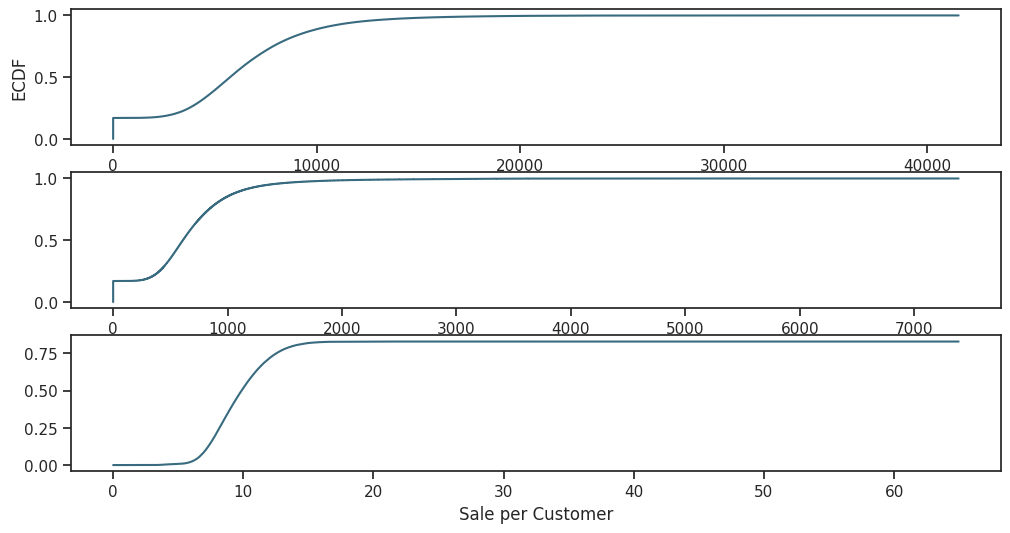

In [63]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

#### Missing Values

##### Closed stores and zero sales stores

In [64]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [65]:
print(train[(train.Open == 0) & (train.Sales == 0)].shape)

(172817, 13)


There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [66]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


Interestingly enough, there are opened store with **no sales on working days**. There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.

In [67]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


Store information:

In [68]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


* Store: a unique Id for each store
* StoreType: differentiates between 4 different store models: a, b, c, d
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [69]:
# missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We have few variables with missing values that we need to deal with. Let's start with the CompetitionDistance.

In [70]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


There is no pattern in here. In this case, it makes a complete sense to replace NaN with the median values (because dataset is skewed).

In [71]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [72]:
# Filter stores with missing 'Promo2SinceWeek' values (no promo info)
promo = store[store['Promo2SinceWeek'].isnull()]

# Filter stores with non-zero 'Promo2' values (stores with active promos)
promo_active = promo[promo['Promo2'] != 0]

# Get the shape (number of rows and columns) of the filtered dataframe
promo_active_shape = promo_active.shape

# Print the shape
print(promo_active_shape)


(0, 10)


No, if there's no **Promo2** then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**.

In [73]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [74]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


### Store Types

In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [75]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


**StoreType B** has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of **Sales and Customers** to see which **StoreType** is the most selling and crowded one:

In [76]:
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()


,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly stores of type A. **StoreType** D goes on the second place in both **Sales and Customers**. What about date periods? Seaborn's facet grid is the best tool for this task:

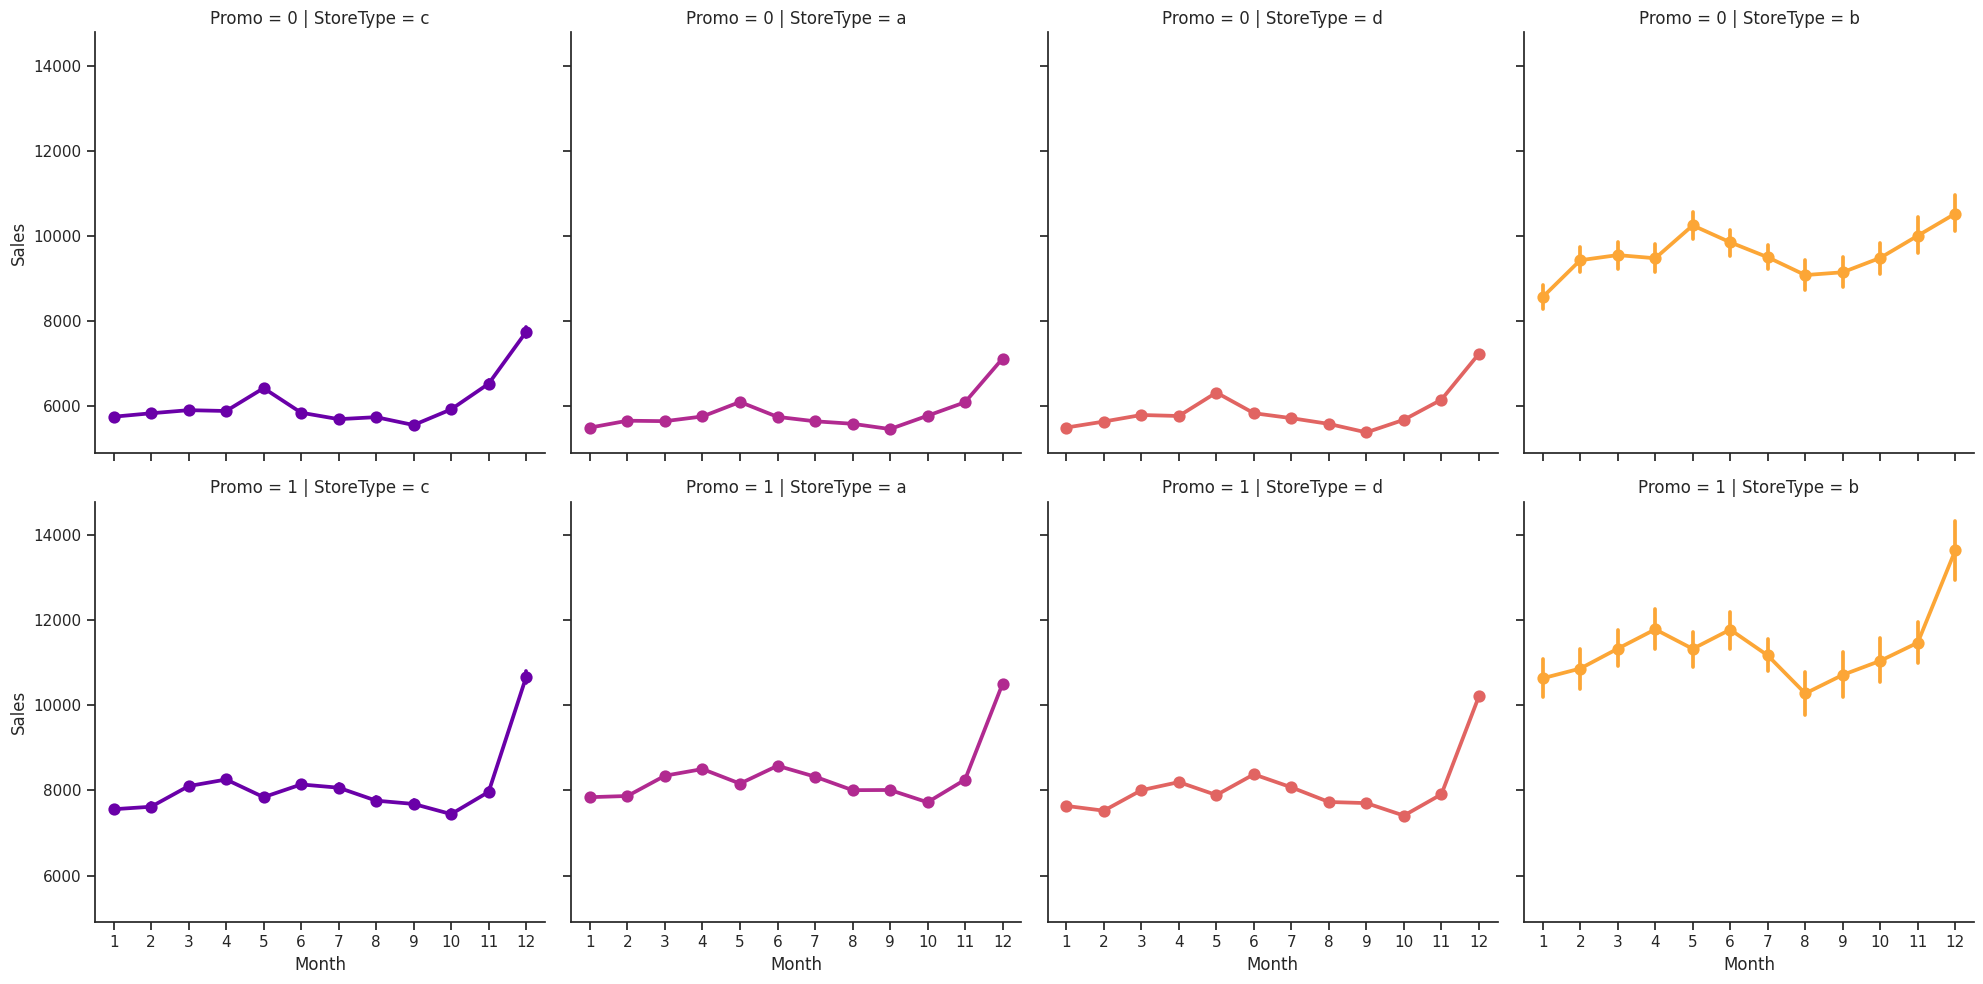

In [77]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind='point') 

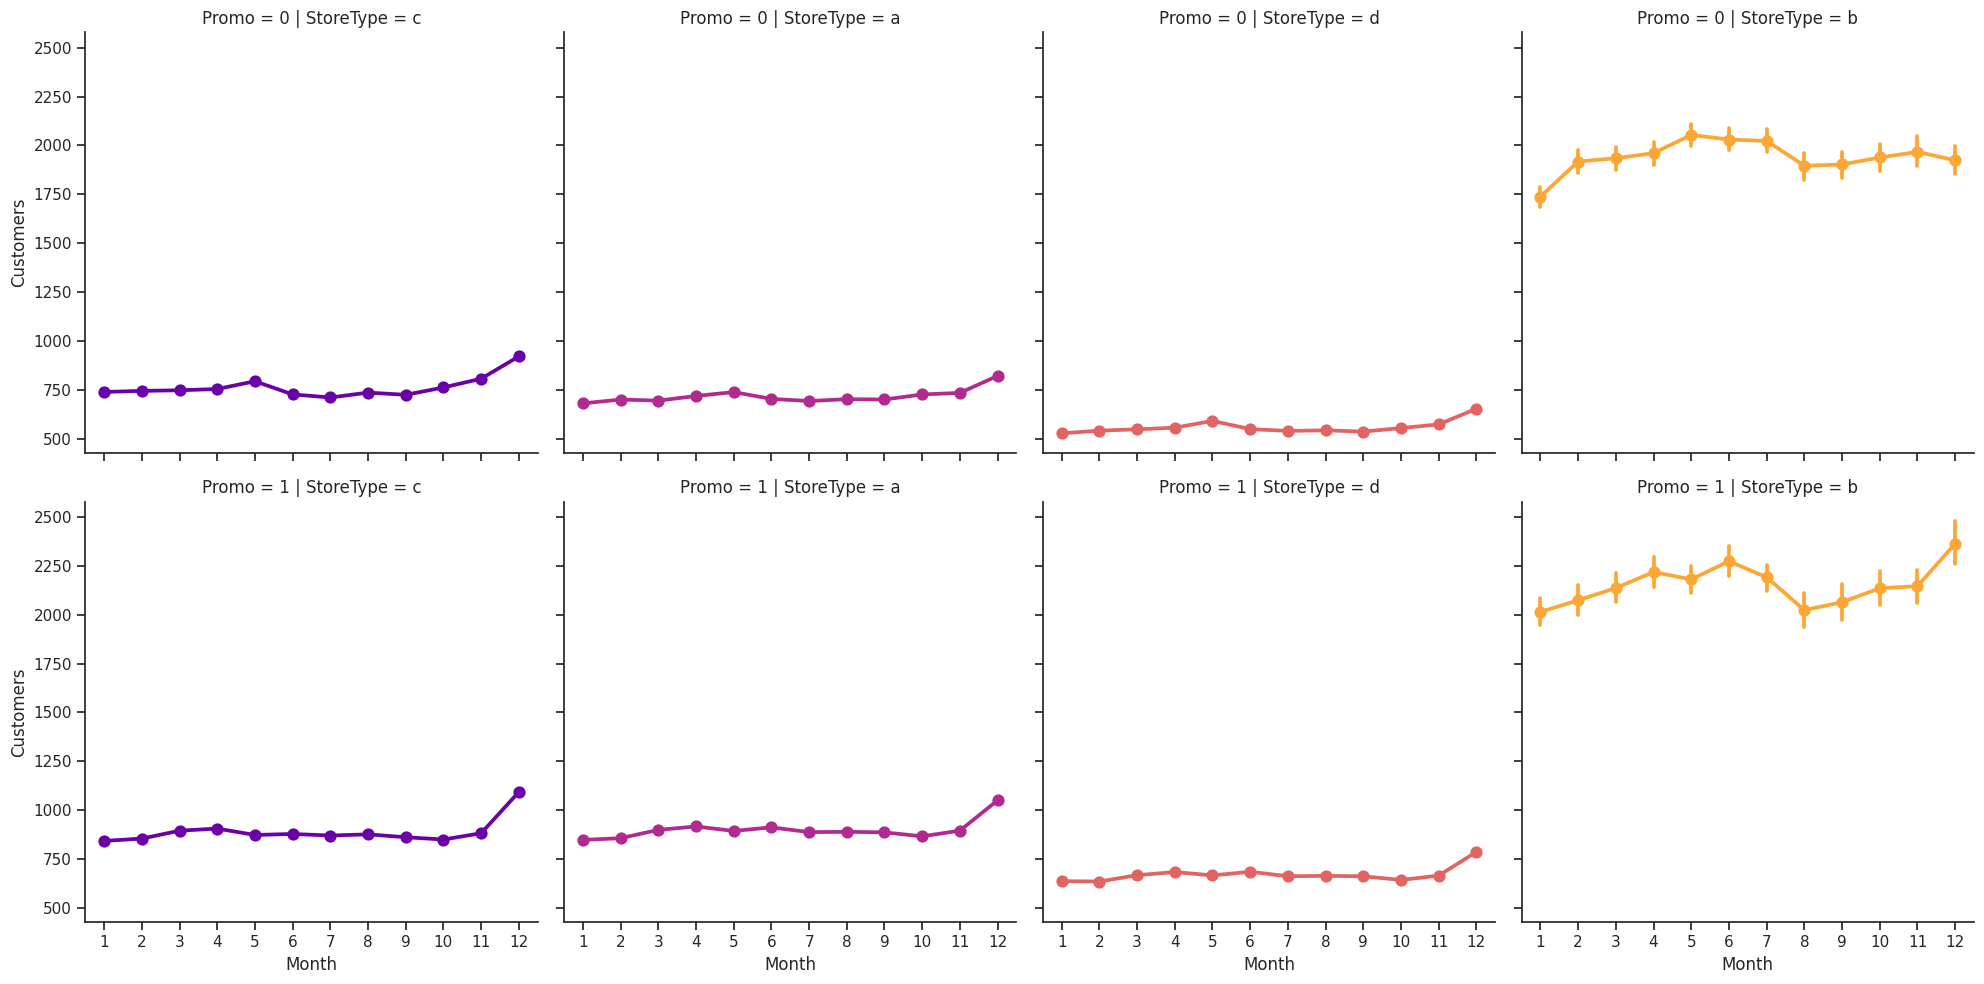

In [78]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind='point') 

All store types follow the same trend but at different scales depending on the presence of the (first) promotion **Promo** and **StoreType** itself (case for B).

**Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.**

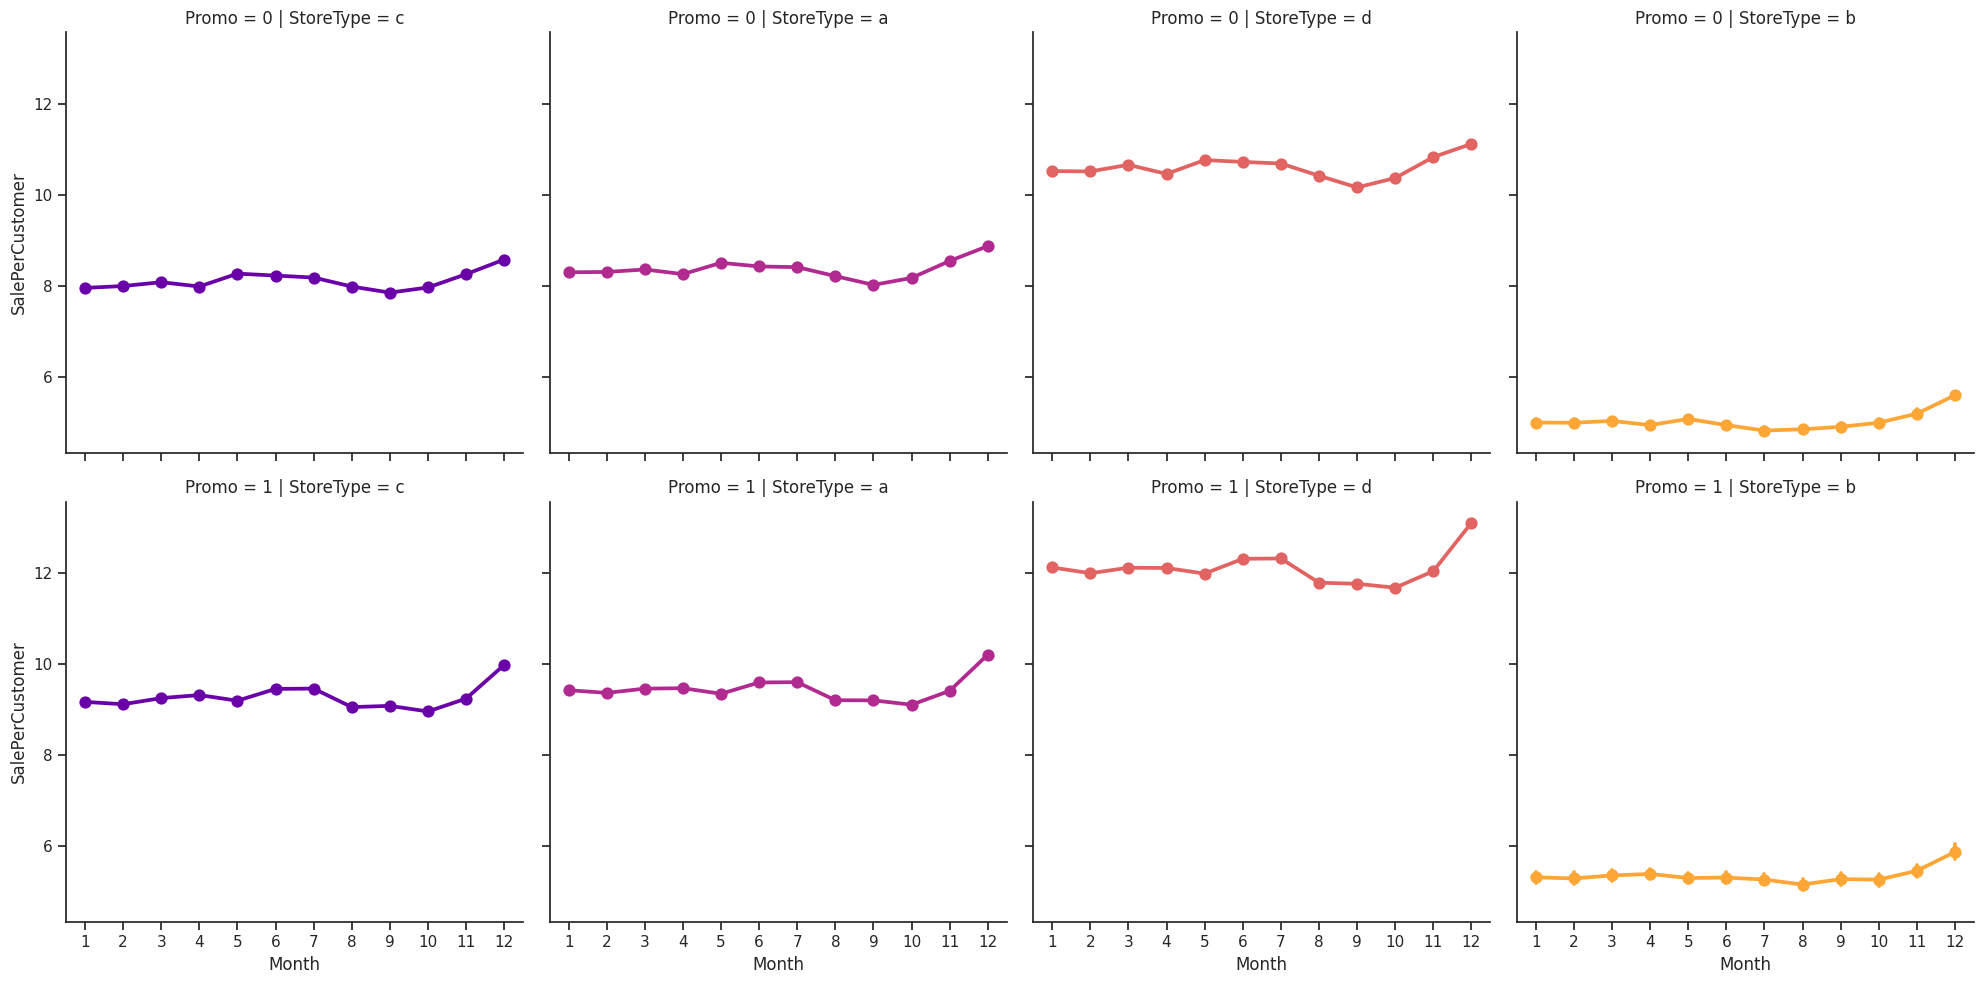

In [79]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind='point') 

While initial visualizations might suggest StoreType B as the top performer in terms of sales, a closer look reveals a different story. StoreType D actually boasts the highest average sales per customer, reaching around €12 with promotions and €10 without. StoreTypes A and C also hover around €9 in average sales per customer.

This lower average sales figure for StoreType B indicates a distinct customer behavior: many individuals frequent these stores for smaller purchases or smaller quantities of goods. Additionally, our data shows that StoreType B consistently generated the lowest overall sales and customer traffic throughout the analyzed period.

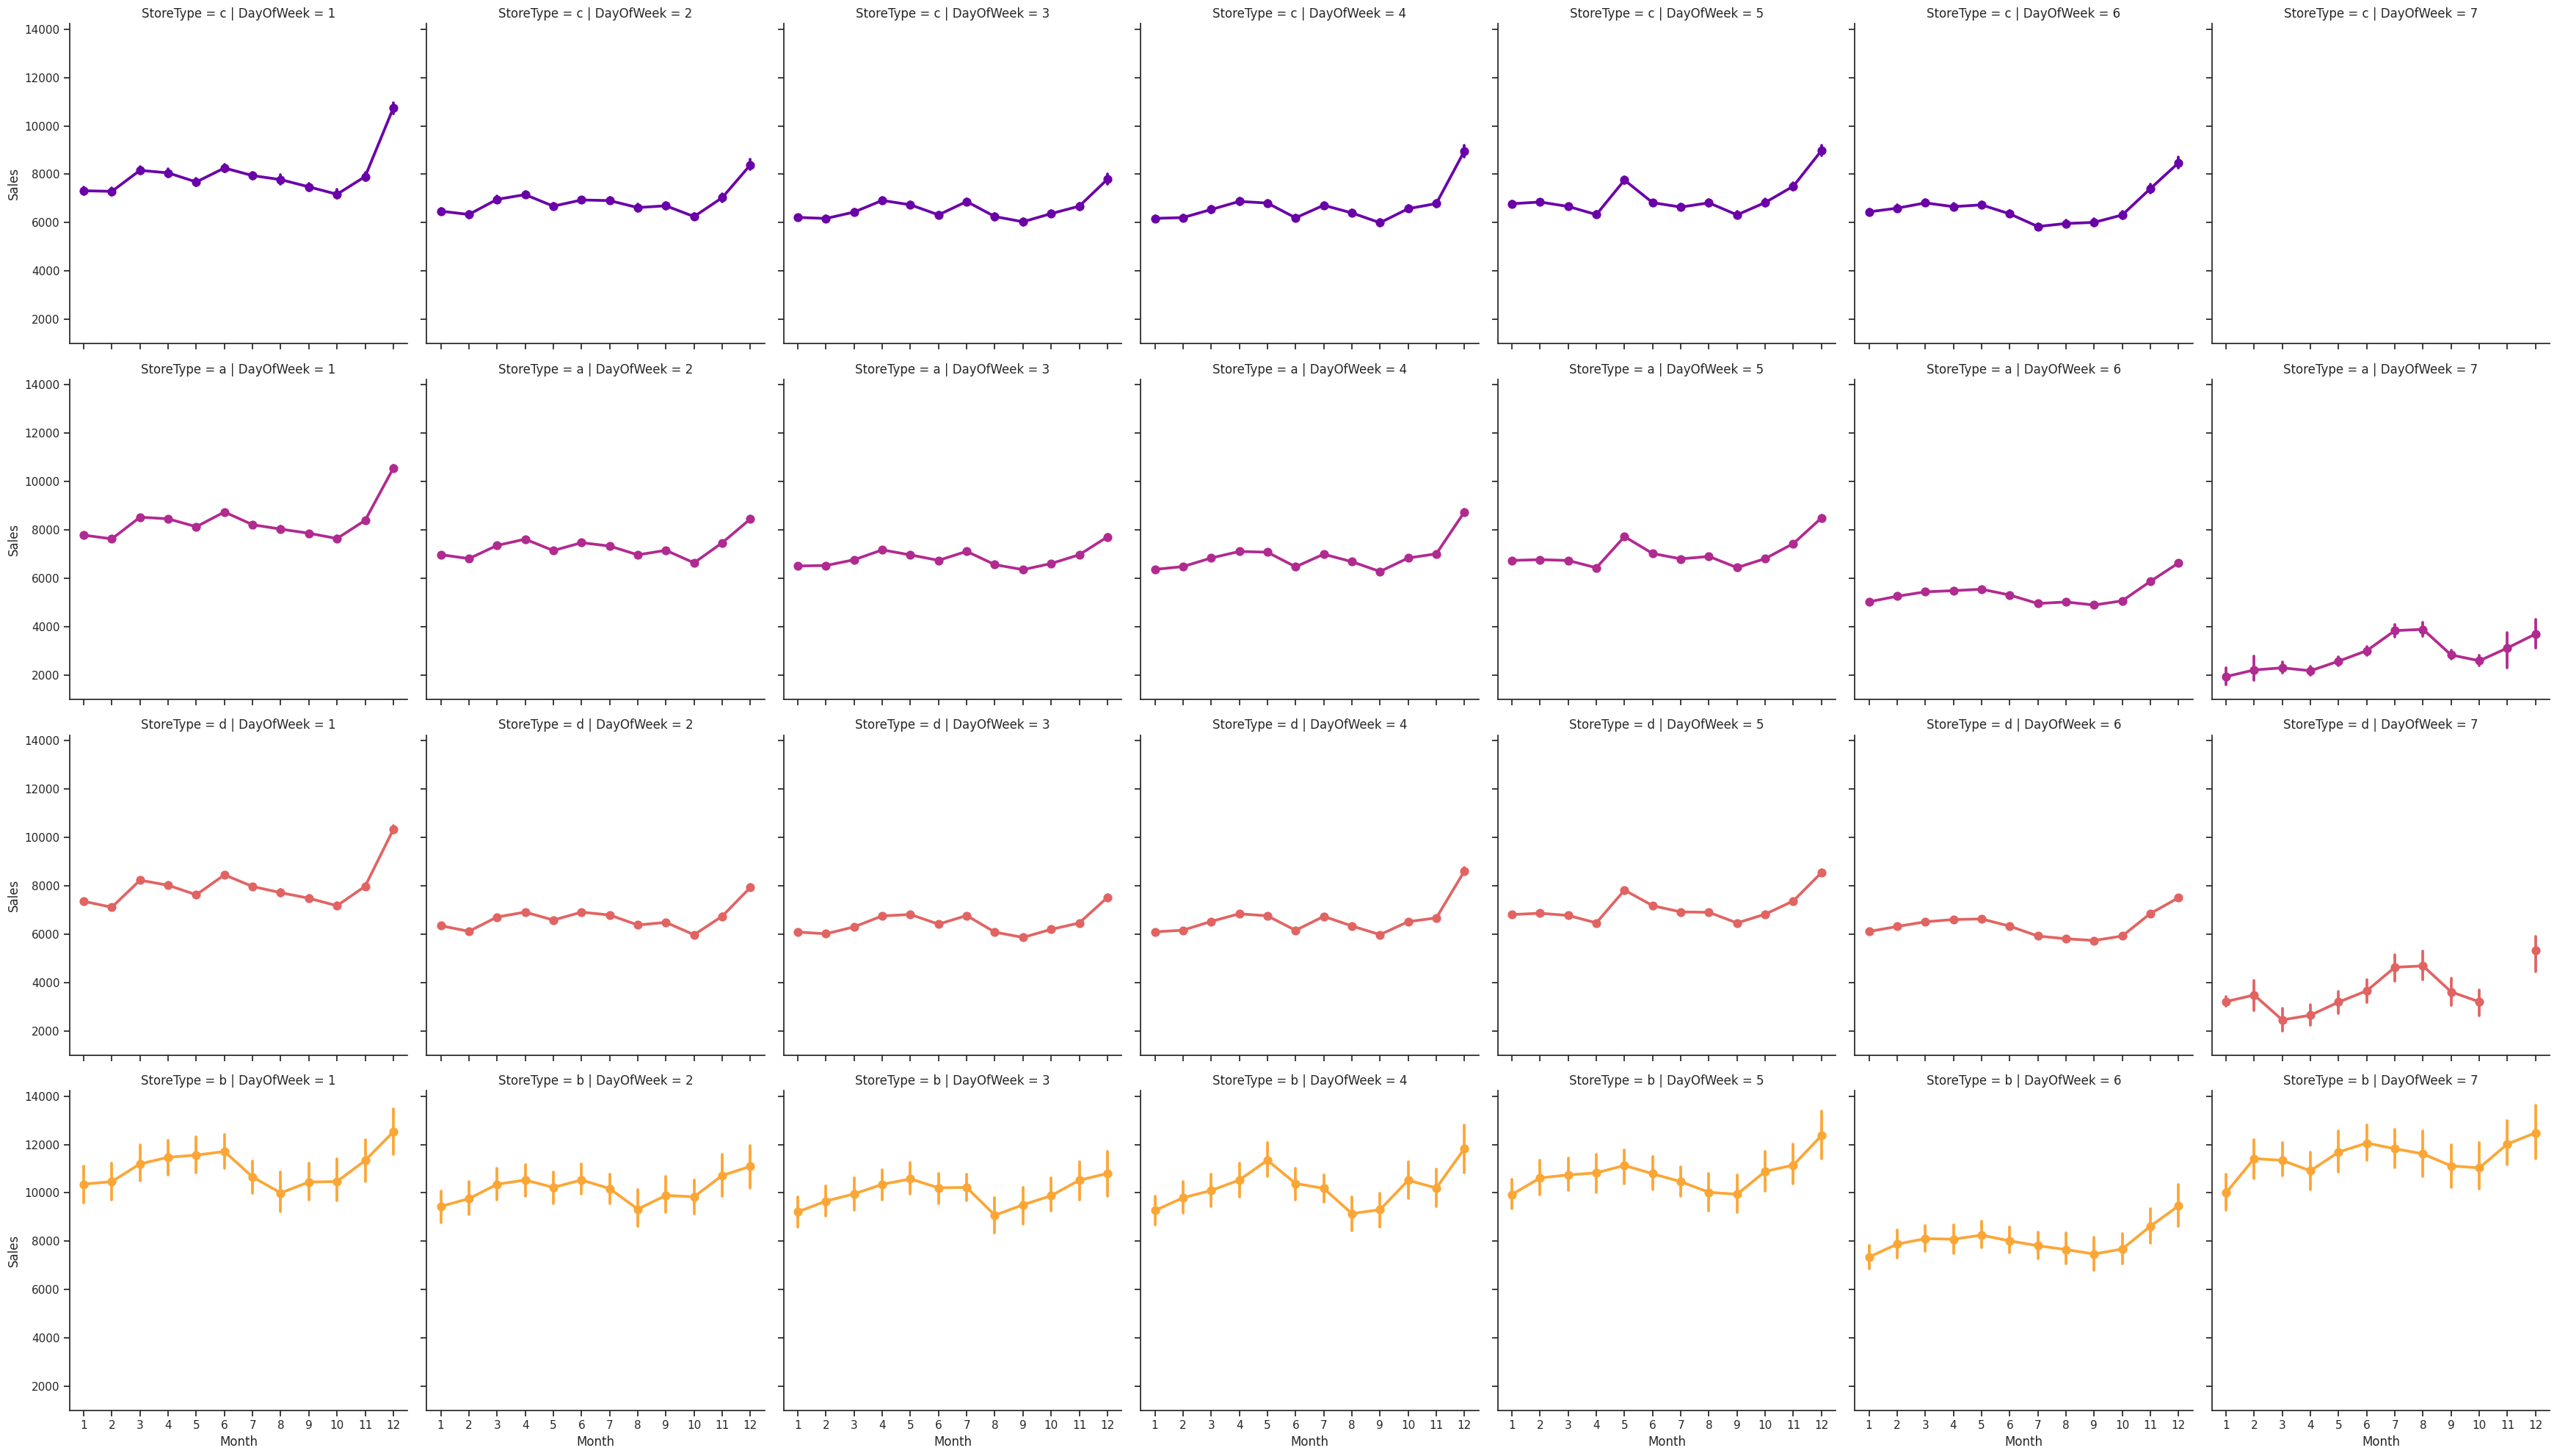

In [80]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c,
               kind= 'point') 

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

Bt the way what are the stores which are opened on Sundays?

In [81]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [82]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.

In [83]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
1,2,5,6064,625,1,1,0,1,2015,7,...,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",92.0,64.5
2,3,5,8314,821,1,1,0,1,2015,7,...,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",103.0,52.25
3,4,5,13995,1498,1,1,0,1,2015,7,...,c,620.0,9.0,2009.0,0,0.0,0.0,0,70.0,24187.75
4,5,5,4822,559,1,1,0,1,2015,7,...,a,29910.0,4.0,2015.0,0,0.0,0.0,0,3.0,24187.75


In [84]:
for col in train_store[['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']]:
    unique_values = train_store[col].unique()
    print(f"Unique values in column '{col}': {unique_values}")


Unique values in column 'StateHoliday': ['0' 'a' 'b' 'c' 0]
Unique values in column 'StoreType': ['c' 'a' 'd' 'b']
Unique values in column 'Assortment': ['a' 'c' 'b']
Unique values in column 'PromoInterval': [0 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [85]:
print(train_store.dtypes)
train_store[['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']]

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
Year                           int32
Month                          int32
Day                            int32
WeekOfYear                    UInt32
SalePerCustomer              float64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
CompetitionOpen              float64
PromoOpen                    Float64
dtype: object


,StateHoliday,StoreType,Assortment,PromoInterval
0,0,c,a,0
1,0,a,a,"Jan,Apr,Jul,Oct"
2,0,a,a,"Jan,Apr,Jul,Oct"
3,0,c,c,0
4,0,a,a,0
...,...,...,...,...
844333,a,b,a,0
844334,a,b,b,0
844335,a,b,b,"Jan,Apr,Jul,Oct"
844336,a,b,b,0


### Correlation Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the seaborn heatmap:

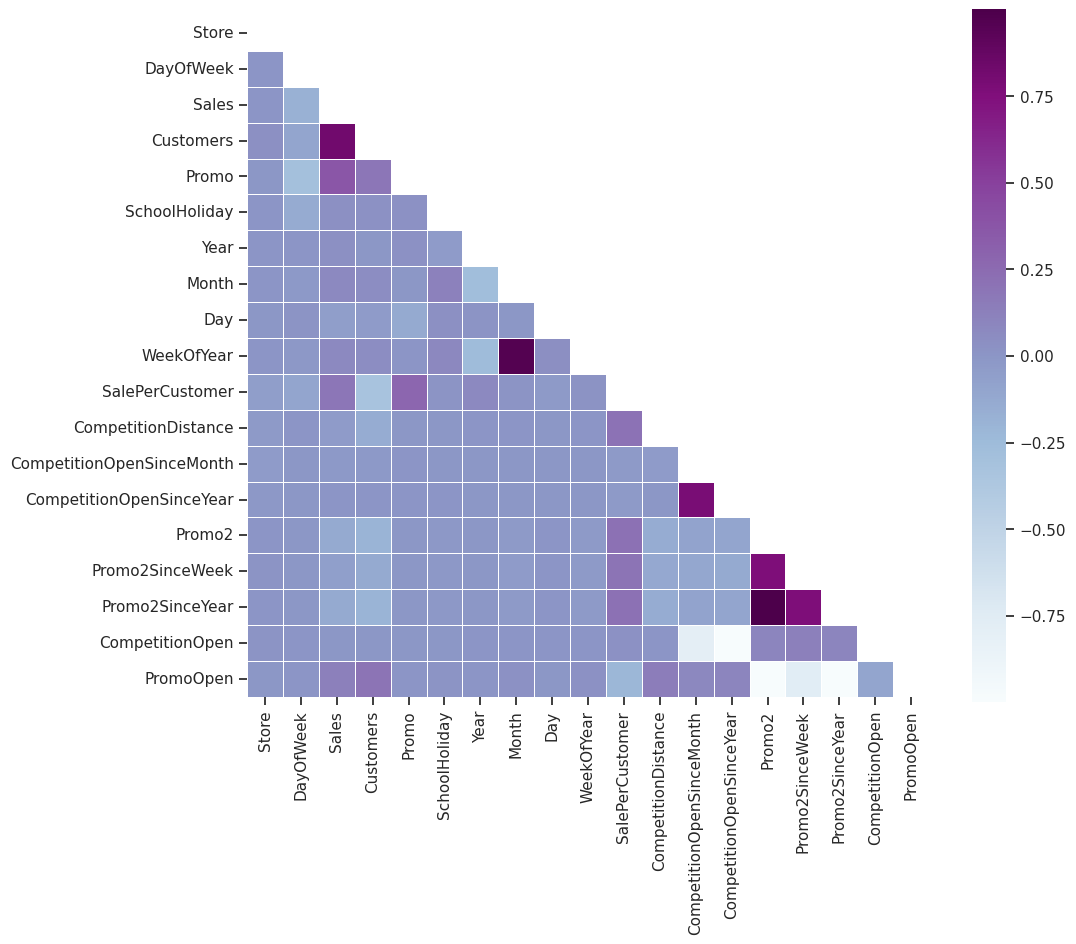

In [86]:
# Compute the correlation matrix 
# exclude 'Open' variable
numerical_columns = train_store.select_dtypes(include=[np.number])  #Some variables are still object
                                                                    # (['StateHoliday', 'StoreType',
                                                                    #'Assortment', 'PromoInterval']) We will exclude them.
corr_all = numerical_columns.drop(['Open'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()


As mentioned before, we have a strong positive correlation between the amount of **Sales and Customers** of a store. We can also observe a positive correlation between the fact that the store had a **running promotion (Promo equal to 1) and amount of Customers**.

However, as soon as the store continues a consecutive promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

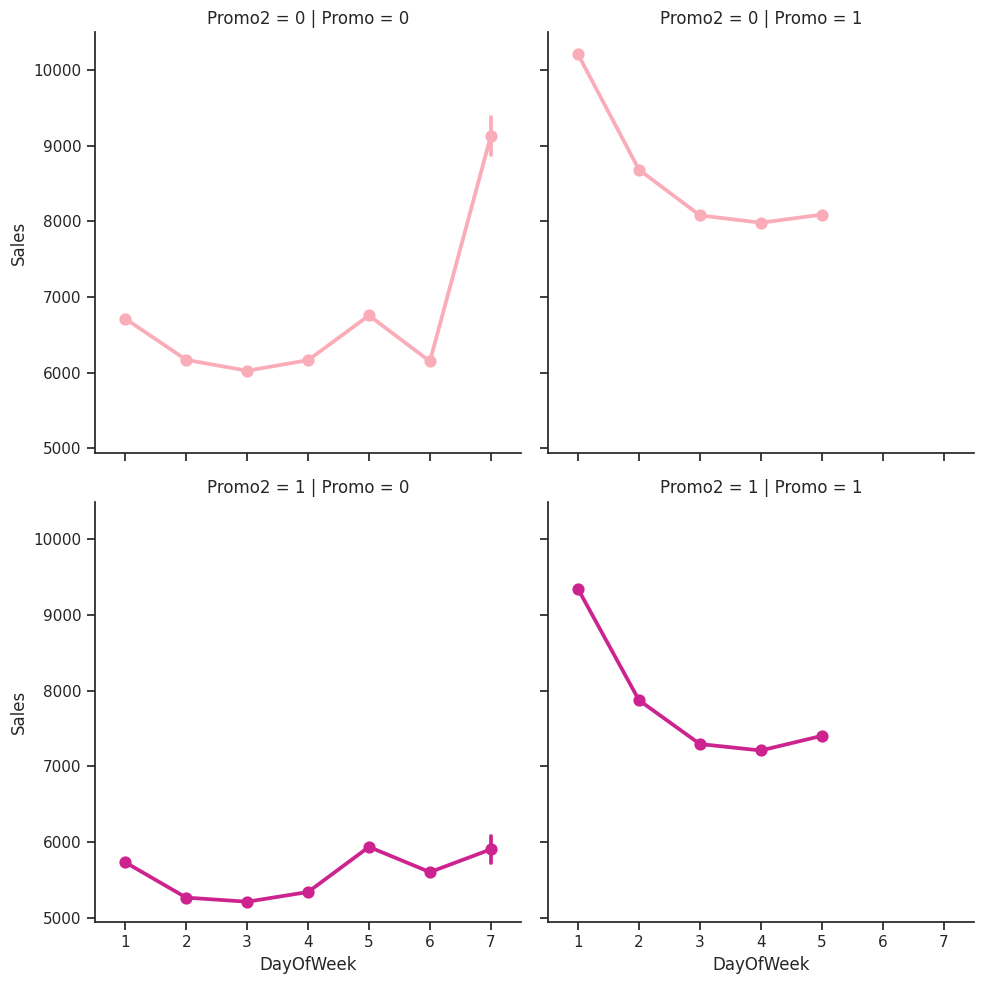

In [87]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu',
               kind='point') 

There are several things here:
* In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.
* On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).
* Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

</div>
<hr style="opacity: 0.5;">
</div>

#### Conclusion of EDA
* The most selling and crowded StoreType is A.
* The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider proposing bigger variety of its products.
* Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small" things. Eventhough this StoreType generated the least amount of sales and customers over the whole period, it shows a great potential.
* Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0).
* Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

### Time-Series Analysis per Store Type

What makes a time series different from a regular regression problem?

* It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.
* Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset.

In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.

#### Seasonality
We take four stores from store types to represent their group:
* Store number 2 for StoreType A
* Store number 85 for StoreType B,
* Store number 1 for StoreType C
* Store number 13 for StoreType D.

It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

<Axes: xlabel='Date'>

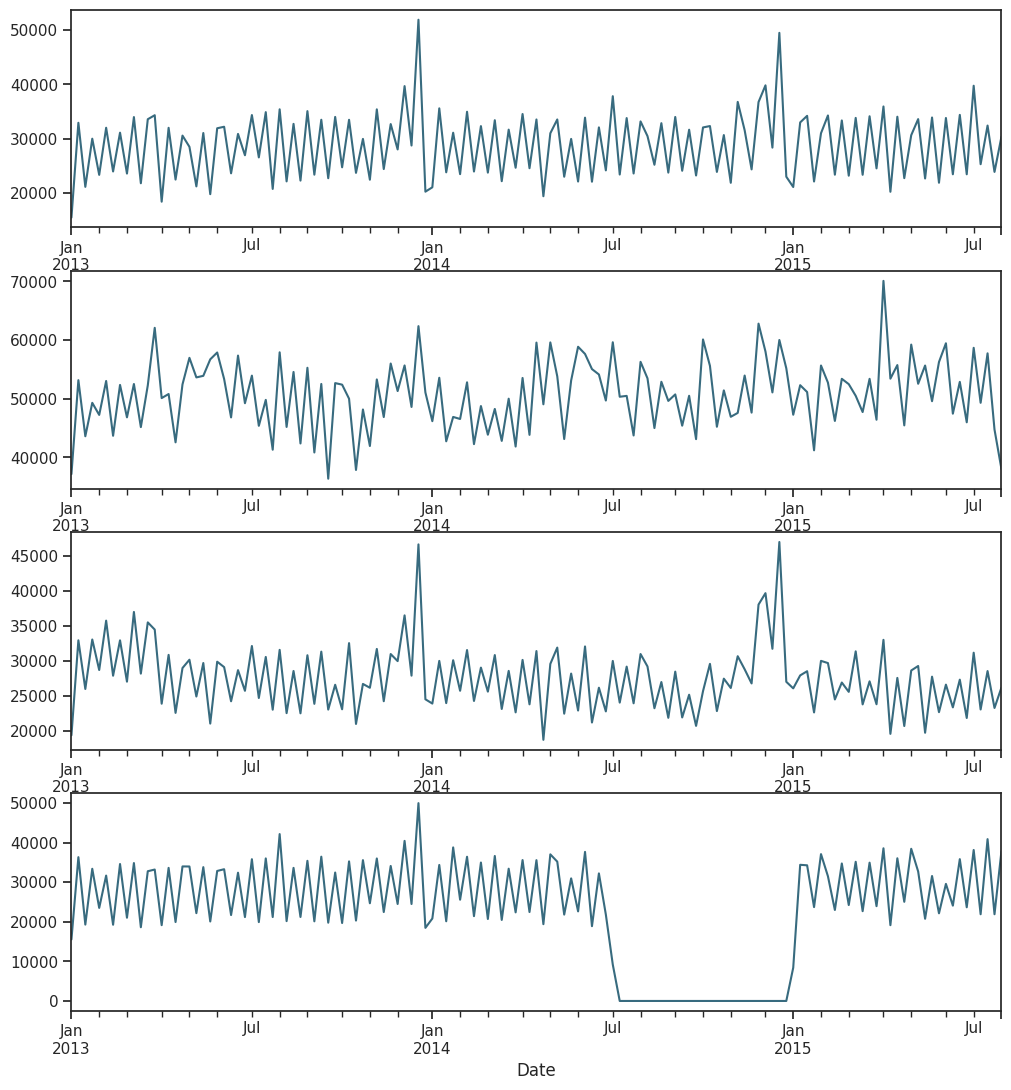

In [88]:
# preparation: input should be float type
train['Sales'] = train['Sales'].astype(float)

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending=True)  # Solve reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# Weekly resampling and plotting
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))
sales_a.resample('W').sum().plot(color=c, ax=ax1)
sales_b.resample('W').sum().plot(color=c, ax=ax2)
sales_c.resample('W').sum().plot(color=c, ax=ax3)
sales_d.resample('W').sum().plot(color=c, ax=ax4)

Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

#### **Yearly trend**

The next thing to check the presence of a trend in series.

In [89]:
sales_d

Date
2015-07-31    8821.0
2015-07-30    7648.0
2015-07-29    6648.0
2015-07-28    6819.0
2015-07-27    7926.0
               ...  
2013-01-07    8246.0
2013-01-05    4285.0
2013-01-04    3848.0
2013-01-03    3674.0
2013-01-02    3737.0
Name: Sales, Length: 621, dtype: float64

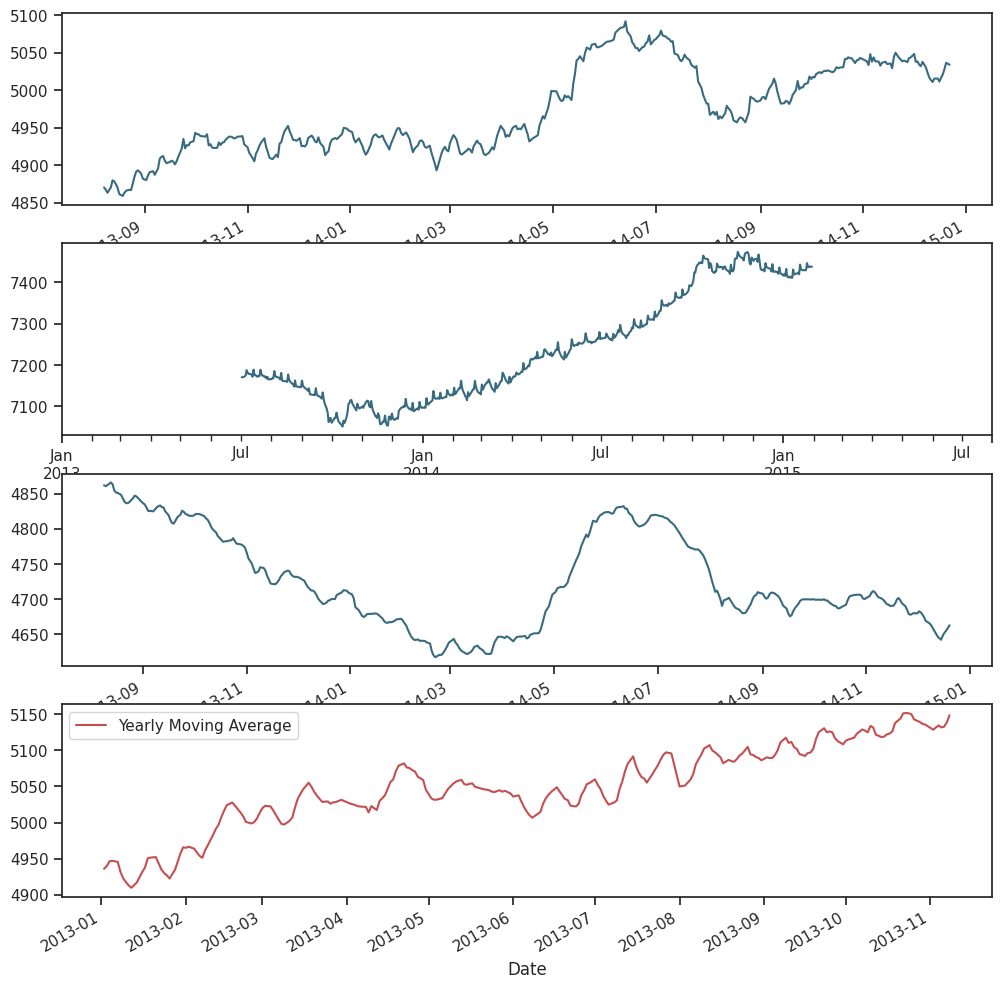

In [90]:
# Monthly seasonal decomposition
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))
decomposition_a = seasonal_decompose(sales_a, model='additive', period=365)
decomposition_a.trend.plot(color=c, ax=ax1)

decomposition_b = seasonal_decompose(sales_b, model='additive', period=365)
decomposition_b.trend.plot(color=c, ax=ax2)

decomposition_c = seasonal_decompose(sales_c, model='additive', period=365)
decomposition_c.trend.plot(color=c, ax=ax3)

# Handle insufficient data in sales_d:
if len(sales_d) >= 730:
    # Perform seasonal decomposition if data is sufficient
    decomposition_d = seasonal_decompose(sales_d, model='additive', period=365)
    decomposition_d.trend.plot(color=c, ax=ax4)
else:
    # Choose an alternative approach (e.g., moving average)
    sales_d_ma = sales_d.rolling(window=365).mean()
    sales_d_ma.plot(color='r', label='Yearly Moving Average', ax=ax4)
    plt.legend()

plt.show()

Overall sales seems to increase, however not for the StoreType C (a third from the top). Eventhough the StoreType A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as StoreType C did.

sales_d didn't have enough data (lower than 720). Therefore, we used yearly moving average.

Image below is an example from original notebook.

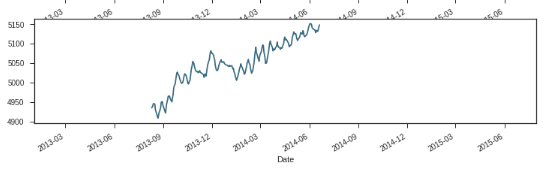




### Autocorrelation


The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

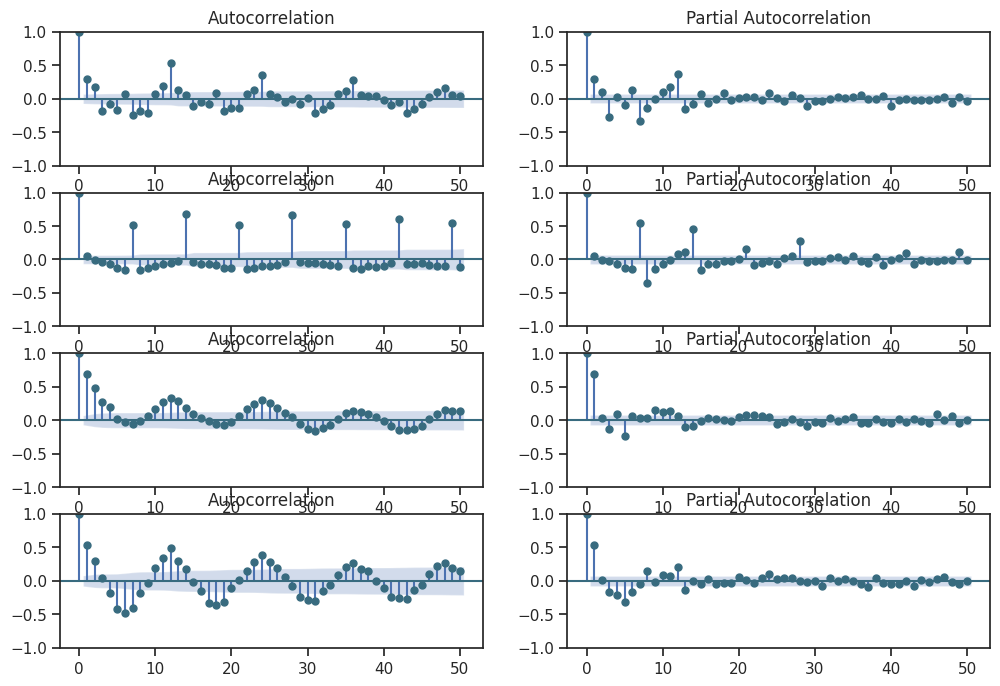

In [91]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

* Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
* Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.

### Time Series Analysis and Forecasting with Prophet

Forecasting for the next 6 weeks for the first store
The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called [Prophet](https://research.fb.com/prophet-forecasting-at-scale/). It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing [automated forecasting which are already implemented in R](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) at scale in Python 3.

In [92]:
# importing data
df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [93]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


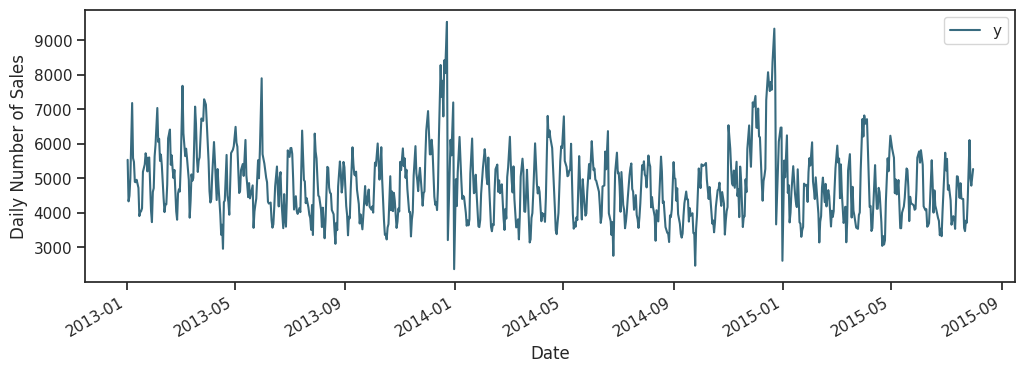

In [94]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

#### Modeling Holidays

Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [95]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [96]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

08:10:10 - cmdstanpy - INFO - Chain [1] start processing
08:10:10 - cmdstanpy - INFO - Chain [1] done processing


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [97]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4105.068154,2513.042327,5785.464383
817,2015-09-06,4078.219404,2446.830518,5748.076298
818,2015-09-07,4176.189484,2492.561790,5788.242460
819,2015-09-08,3678.501494,2088.529758,5434.897340
820,2015-09-09,3564.668762,1928.815785,5100.077022
821,2015-09-10,3476.638570,1855.310396,5140.084258
822,2015-09-11,3732.007353,2140.999955,5344.752669


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [98]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

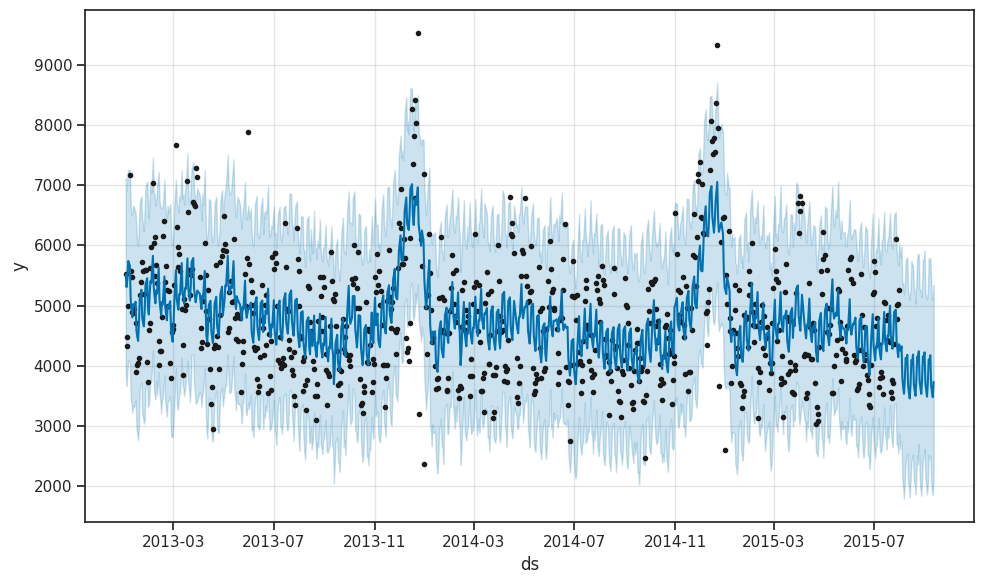

In [99]:
# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manually included holidays contribute to the overall forecasted values:

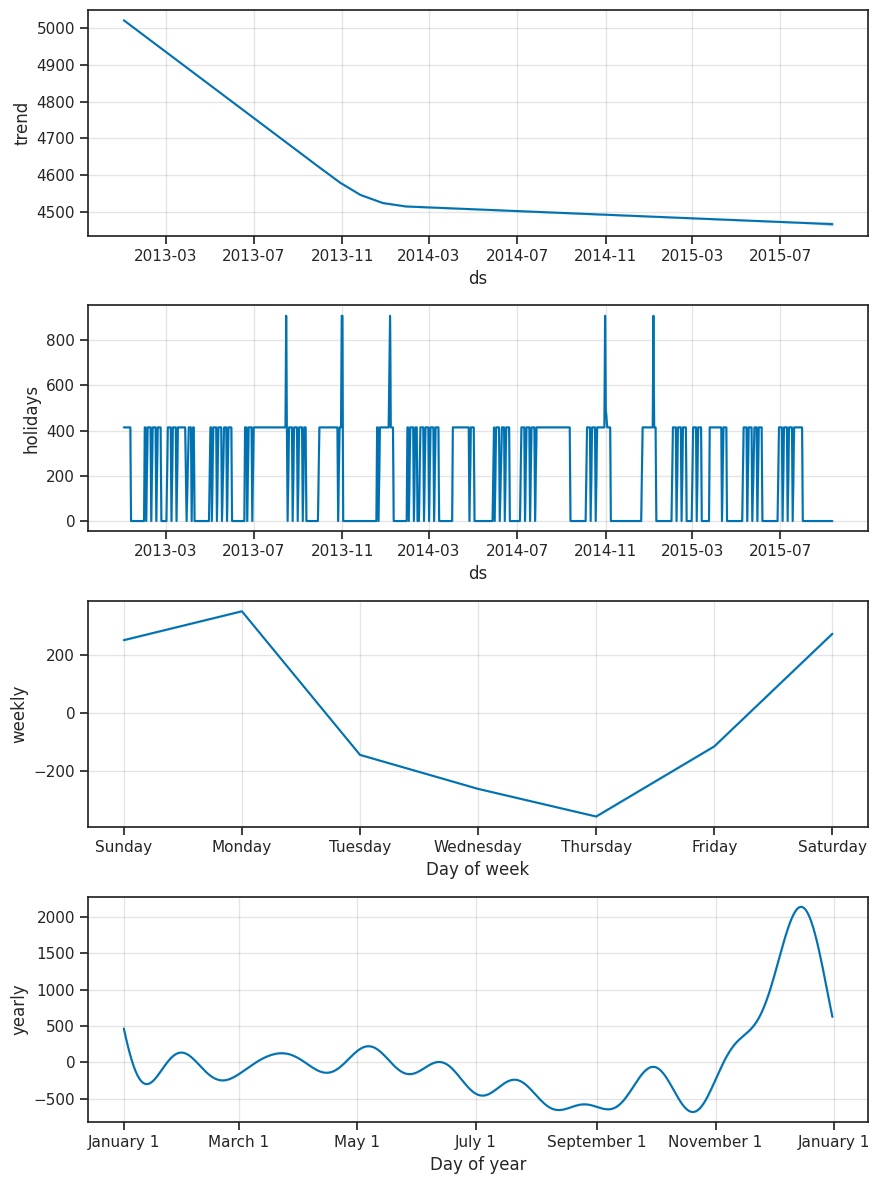

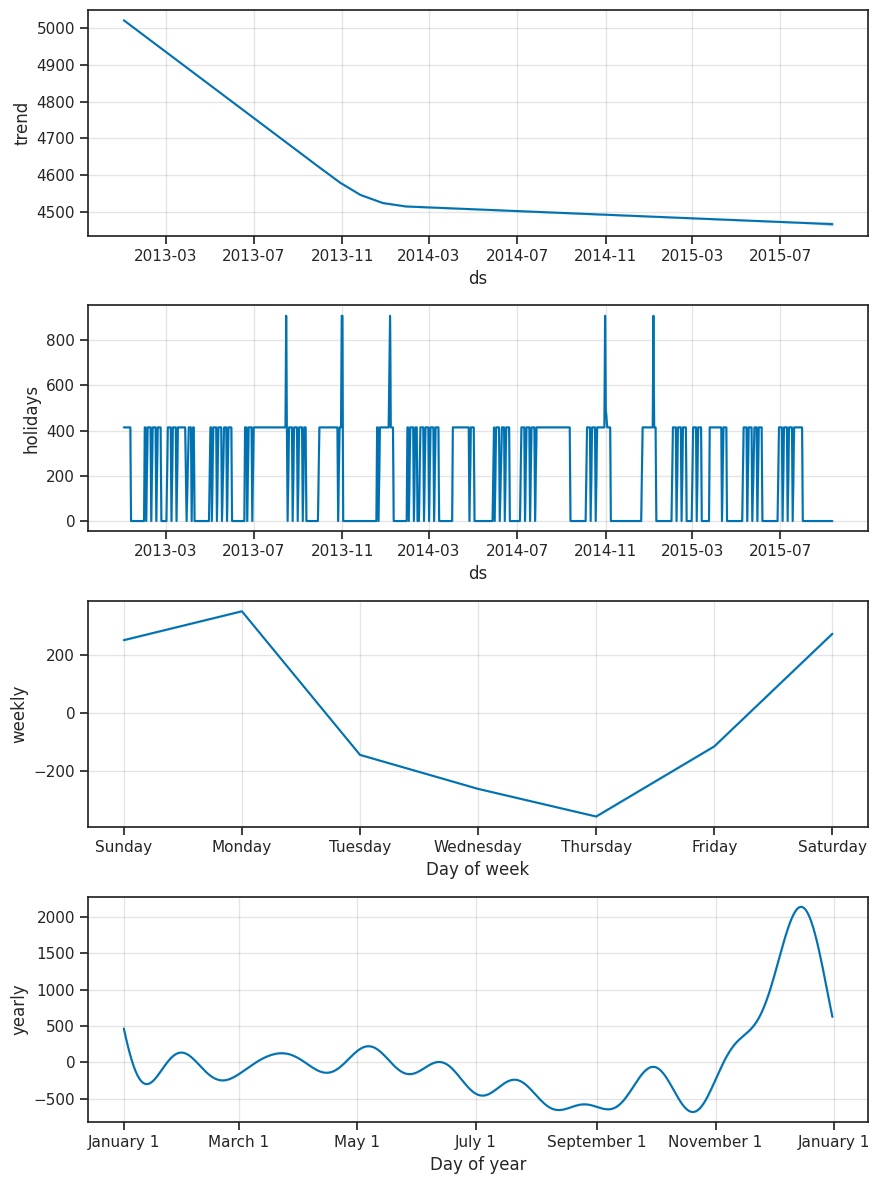

In [100]:
my_model.plot_components(forecast)

The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

#### Conclusion of Time Series forecasting

During this part, we discussed time series analysis with .seasonal_decompose(), ACF and PCF plots and fitted forecasting model using a new procedure by Facebook Prophet.

We can now present main advantages and drawbacks of time series forecasting:

**Advantages**

* A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manually).
* Easily implemented with R auto.arima() from forecast package, which runs a complex grid search and sophisticated algorithm behind the scene.

**Drawbacks**

* Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are Promo and CompetitionOpen.
* Even though Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
* Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.
* Seasonal ARIMA in Python has 7 hyper parameters which can be tuned only manually affecting significantly the speed of the forecasting process.

In [103]:
fc.head()

,ds,yhat
0,2013-01-02,5518.969136
1,2013-01-03,5308.522220
2,2013-01-04,5446.634376
3,2013-01-05,5742.533496
4,2013-01-07,5664.075963


In [104]:
# Assuming 'ds' is the date column and 'yhat' is the prediction column in fc

# Reset the index to use it as Id
fc = fc.reset_index(drop=False)  # Drops the old index if needed

# Rename the index column to 'Id' (optional)
fc.rename(columns={'index': 'Id'}, inplace=True)  # Optional renaming

# Select Id and yhat for submission dataframe
submission = fc[['Id', 'Sales']]

# Export the submission dataframe to a CSV file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")


Submission file 'submission.csv' created successfully!
